In [5]:
import numpy as np
import scipy as sp
import scipy.signal
import matplotlib.pyplot as plt

In [6]:
def CreateCheckerImage(size=None, grid_size=None, col1=None, col2=None):
    if(size is None):
        size = [256,256,3];
    w = size[1];
    h = size[0];
    if(col1 is None):
        col1 = np.ones(3);
    if(col2 is None):
        col2 = np.zeros(3);
    im = np.zeros(size).astype(np.float64);
    if(grid_size is None):
        grid_size = int(min(w,h)/25);
    # Make pixels white where (row+col) is odd
    for i in range(w):
        for j in range(w):
            if (i//grid_size + j//grid_size)%2:
                im[i,j] = col1
            else:
                im[i,j] = col2
    return im;

In [7]:
def showIm(im):
    im2show = im;
    if(len(im.shape)==3 and im.shape[2]==2):
        im2show=np.dstack((im[:,:,0],im[:,:,1],np.ones_like(im[:,:,0])));
    plt.imshow(im2show);
    plt.show()

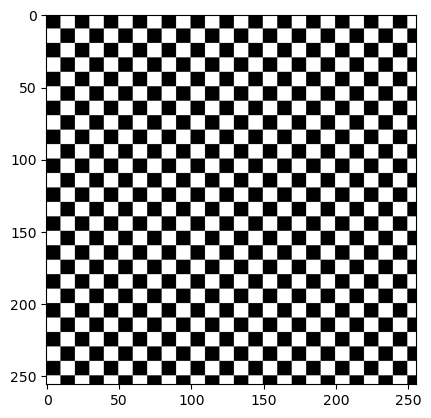

In [8]:
checker = CreateCheckerImage();
showIm(checker)

In [9]:
def computeWarpField(size, warp_sample_size=None, noise_scale=None, warp_probability=1.0, fftconvolve=True, rng=None):
    """
    Generates warp field
    output is [height, width,2]
    each value [y,x] is the normalized coordinate that you will sample from to get the warped image
    these are floating point, so we will need to interpolate
    
    warp_probability is the probability of warping each vertex. So each vertex is randomly either warped or not.
    fftconvolve will make things WAY faster if you have a small warp_sample_size compared to size
    rng is an optional random number generator, which you can seed if you like
    """
    if(rng is None):
        rng = np.random.default_rng();
    
    sparse = np.zeros(size);
    if(noise_scale is None):
        noise_scale = 0.5;
    if(warp_sample_size is None):
        warp_sample_size = np.array([int(size[0]*0.1),int(size[1]*0.1), 2]);
        
    X = np.linspace(0,1,warp_sample_size[1])
    Y = np.linspace(0,1,warp_sample_size[0])    
    xx,yy = np.meshgrid(X,Y)
    start_samples = np.dstack((yy,xx));
    warp_samples = start_samples.copy();
    x_range = X[1]*2*noise_scale;
    y_range = Y[1]*2*noise_scale;
    
    y_warp_amount = y_range*(rng.random(warp_sample_size[:2])-0.5);
    x_warp_amount = x_range*(rng.random(warp_sample_size[:2])-0.5);
    
    switch_displacements = rng.random(warp_sample_size[:2])>warp_probability;
    y_warp_amount[switch_displacements]=0;
    x_warp_amount[switch_displacements]=0;
    
    
#     warp_samples[:,:,0]=warp_samples[:,:,0]+y_warp_amount;
#     warp_samples[:,:,1]=warp_samples[:,:,1]+x_warp_amount;
    warp_samples[:,:,0]=y_warp_amount;
    warp_samples[:,:,1]=x_warp_amount;

    windowx = int(3*size[1]/warp_sample_size[1]);
    stdx = size[1]/(2*warp_sample_size[1]);
    windowy = int(3*size[0]/warp_sample_size[0]);
    stdy = size[0]/(2*warp_sample_size[0]);
    
#     def kst(wind):
#         return np.sqrt(((wind**2)-1)/12);
    
    sigy = sp.signal.windows.gaussian(windowy, std=stdy);
    sigx = sp.signal.windows.gaussian(windowx, std=stdx);
#     sigy = sp.signal.windows.gaussian(windowy, std=kst(windowy));
#     sigx = sp.signal.windows.gaussian(windowx, std=kst(windowx));
    kernel = np.outer(sigy, sigx);
    kernel = kernel/np.sum(kernel);

    start_sample_inds = start_samples.copy();
    start_sample_inds[:,:,0]=np.clip(start_sample_inds[:,:,0]*size[0],0,size[0]-1);
    start_sample_inds[:,:,1]=np.clip(start_sample_inds[:,:,1]*size[1],0,size[1]-1);
    start_sample_inds = start_sample_inds.astype(np.int64)


    coords = np.zeros([size[0],size[1],3]);
    coords[start_sample_inds[:,:,0],start_sample_inds[:,:,1],:2]=warp_samples
    coords[start_sample_inds[:,:,0],start_sample_inds[:,:,1],2]=1
    
    if(fftconvolve):
        for c in range(3):
            coords[:,:,c] = sp.signal.fftconvolve(coords[:,:,c], kernel, mode='same');
    else:
        for c in range(3):
            coords[:,:,c] = sp.signal.convolve(coords[:,:,c], kernel);
    
    cX = np.linspace(0,1,size[1])
    cY = np.linspace(0,1,size[0])    
    cxx,cyy = np.meshgrid(cX,cY)
    r_samples = np.dstack((cyy,cxx));
        

    coords[:,:,0]=coords[:,:,0]/coords[:,:,2];
    coords[:,:,1]=coords[:,:,1]/coords[:,:,2];
    coords[:,:,:2]= coords[:,:,:2]+r_samples;

    return coords[:,:,:2];
 

In [10]:
sp.signal.windows.gaussian(5, std=1)

array([0.13533528, 0.60653066, 1.        , 0.60653066, 0.13533528])

In [11]:
def sample_warp_field(im, warp_field):
    """
    creates an image outim by assigning each pixel outim[X] of outim the value of im[warp_field[X]].
    since X is floating point, we need to do bilinear interpolation
    """
    inds = warp_field.copy();
    inds[:,:,0]=inds[:,:,0]*im.shape[0];
    inds[:,:,1]=inds[:,:,1]*im.shape[1];

    indsxf = np.clip(
        np.floor(inds[:,:,1]),
        0,
        im.shape[1]-1
    ).astype(np.int64);
    
    indsxc = np.clip(
        np.ceil(inds[:,:,1]),
        0,
        im.shape[1]-1
    ).astype(np.int64);
    
    indsyf = np.clip(
        np.floor(inds[:,:,0]),
        0,
        im.shape[0]-1
    ).astype(np.int64);
    
    indsyc = np.clip(
        np.ceil(inds[:,:,0]),
        0,
        im.shape[0]-1
    ).astype(np.int64);

    indsx = inds[:,:,1]-indsxf;
    indsy = inds[:,:,0]-indsyf;
    
    indsx = np.dstack((indsx,indsx,indsx));
    indsy = np.dstack((indsy,indsy,indsy));

    opixa = (1.0-indsx)*im[indsyf,indsxf]+indsx*im[indsyf,indsxc];
    opixb = (1.0-indsx)*im[indsyc,indsxf]+indsx*im[indsyc,indsxc];
    opix = opixb*indsy+(1.0-indsy)*opixa;
    return opix;





Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


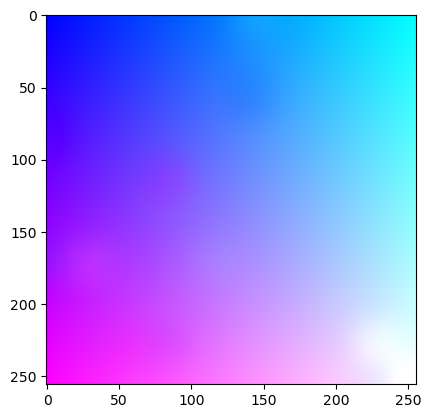

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


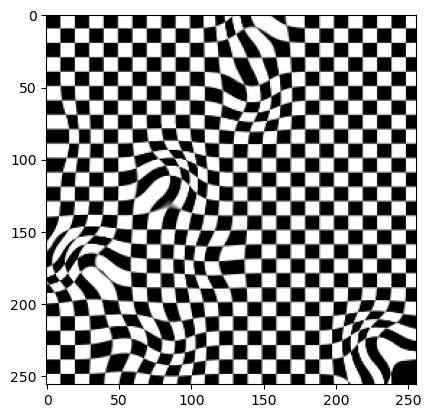

In [12]:
output_image = checker;
rand_sample_grid_size = [10,10];
wf = computeWarpField(
    size=output_image.shape, 
    warp_sample_size=rand_sample_grid_size, 
    noise_scale=1.0, 
    fftconvolve=True, 
    rng=None,
    warp_probability=0.1
)


opix = sample_warp_field(output_image, wf);
showIm(wf)
showIm(opix)




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


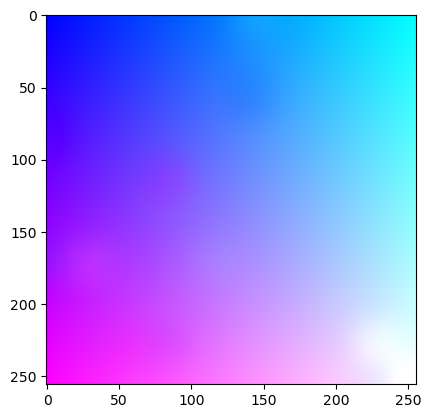

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


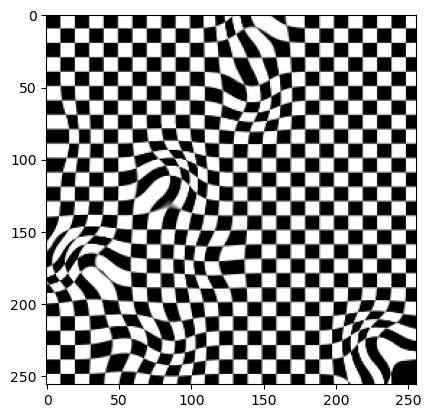

In [13]:
def showWarpField(wfld):
#     showIm(wfld);
#     rim = sample_warp_field(checker, wfld);
#     showIm(rim);
#     return rim;
    plt.imshow(np.dstack((wfld[:,:,0], wfld[:,:,1], np.ones_like(wfld[:,:,0]))));
    plt.show();
    plt.imshow(sample_warp_field(checker, wfld))
    plt.show()
showWarpField(wf)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


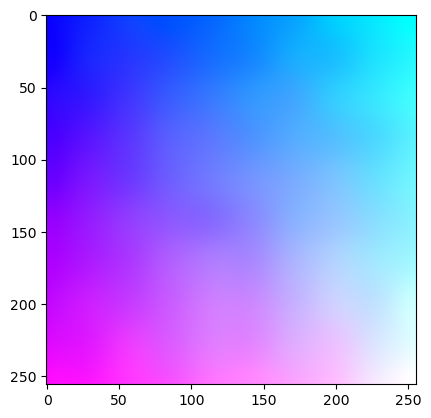

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


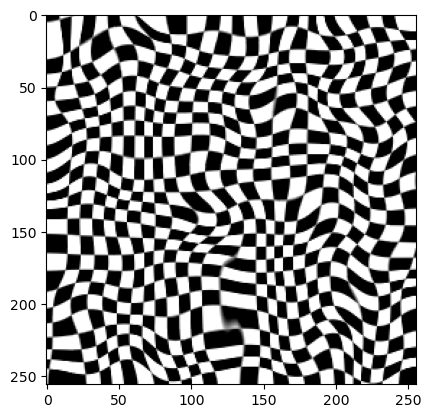

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


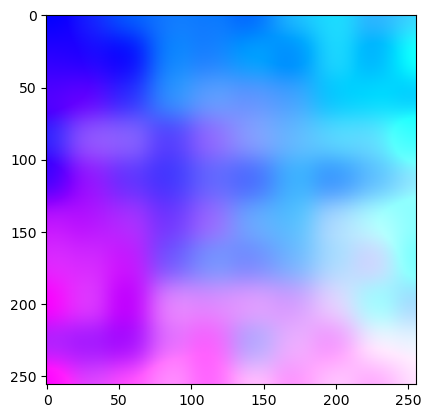

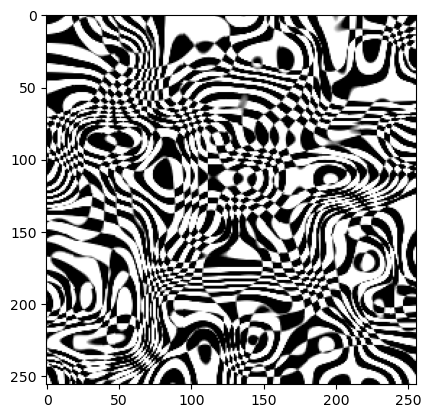

In [14]:
output_image = checker;
rand_sample_grid_size = [10,10];
wf10 = computeWarpField(
    size=output_image.shape, 
    warp_sample_size=rand_sample_grid_size, 
    noise_scale=0.5, 
    fftconvolve=True, 
    rng=None
)
showWarpField(wf10)


wf10strong = computeWarpField(
    size=output_image.shape, 
    warp_sample_size=rand_sample_grid_size, 
    noise_scale=2.5, 
    fftconvolve=True, 
    rng=None
)
showWarpField(wf10strong)






In [23]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
import torch
import torchvision.models as models
from torchvision import transforms as T
import sys
import os
from PIL import Image, ImageFilter 
import numpy as np
import scipy as sp
import scipy.signal
from shutil import copyfile
# import elasticdeform
import cv2 as cv


def sample_warp_field(im, warp_field):
    """
    creates an image outim by assigning each pixel outim[X] of outim the value of im[warp_field[X]].
    since X is floating point, we need to do bilinear interpolation
    """
    inds = warp_field.copy();
    inds[:,:,0]=inds[:,:,0]*im.shape[0];
    inds[:,:,1]=inds[:,:,1]*im.shape[1];

    indsxf = np.clip(
        np.floor(inds[:,:,1]),
        0,
        im.shape[1]-1
    ).astype(np.int);
    
    indsxc = np.clip(
        np.ceil(inds[:,:,1]),
        0,
        im.shape[1]-1
    ).astype(np.int);
    
    indsyf = np.clip(
        np.floor(inds[:,:,0]),
        0,
        im.shape[0]-1
    ).astype(np.int);
    
    indsyc = np.clip(
        np.ceil(inds[:,:,0]),
        0,
        im.shape[0]-1
    ).astype(np.int);

    indsx = inds[:,:,1]-indsxf;
    indsy = inds[:,:,0]-indsyf;
    
    indsx = np.dstack((indsx,indsx,indsx));
    indsy = np.dstack((indsy,indsy,indsy));

    opixa = (1.0-indsx)*im[indsyf,indsxf]+indsx*im[indsyf,indsxc];
    opixb = (1.0-indsx)*im[indsyc,indsxf]+indsx*im[indsyc,indsxc];
    opix = opixb*indsy+(1.0-indsy)*opixa;
    return opix



def computeWarpField(size, warp_sample_size=None, noise_scale=None, warp_probability=1.0, fftconvolve=True, rng=None):
    """
    Generates warp field
    output is [height, width,2]
    each value [y,x] is the normalized coordinate that you will sample from to get the warped image
    these are floating point, so we will need to interpolate
    
    warp_probability is the probability of warping each vertex. So each vertex is randomly either warped or not.
    fftconvolve will make things WAY faster if you have a small warp_sample_size compared to size
    rng is an optional random number generator, which you can seed if you like
    """
    if(rng is None):
        rng = np.random.default_rng();
    
    sparse = np.zeros(size);
    if(noise_scale is None):
        noise_scale = 0.5;
    if(warp_sample_size is None):
        warp_sample_size = np.array([int(size[0]*0.1),int(size[1]*0.1), 2]);
        
    X = np.linspace(0,1,warp_sample_size[1])
    Y = np.linspace(0,1,warp_sample_size[0])    
    xx,yy = np.meshgrid(X,Y)
    start_samples = np.dstack((yy,xx));
    warp_samples = start_samples.copy();
    x_range = X[1]*2*noise_scale;
    y_range = Y[1]*2*noise_scale;
    
    y_warp_amount = y_range*(rng.random(warp_sample_size[:2])-0.5);
    x_warp_amount = x_range*(rng.random(warp_sample_size[:2])-0.5);
    
    switch_displacements = rng.random(warp_sample_size[:2])>warp_probability;
    y_warp_amount[switch_displacements]=0;
    x_warp_amount[switch_displacements]=0;
    
    
#     warp_samples[:,:,0]=warp_samples[:,:,0]+y_warp_amount;
#     warp_samples[:,:,1]=warp_samples[:,:,1]+x_warp_amount;
    warp_samples[:,:,0]=y_warp_amount;
    warp_samples[:,:,1]=x_warp_amount;

    windowx = int(3*size[1]/warp_sample_size[1]);
    stdx = size[1]/(2*warp_sample_size[1]);
    windowy = int(3*size[0]/warp_sample_size[0]);
    stdy = size[0]/(2*warp_sample_size[0]);
    
#     def kst(wind):
#         return np.sqrt(((wind**2)-1)/12);
    
    sigy = sp.signal.windows.gaussian(windowy, std=stdy);
    sigx = sp.signal.windows.gaussian(windowx, std=stdx);
#     sigy = sp.signal.windows.gaussian(windowy, std=kst(windowy));
#     sigx = sp.signal.windows.gaussian(windowx, std=kst(windowx));
    kernel = np.outer(sigy, sigx);
    kernel = kernel/np.sum(kernel);
#     print('here',windowx, windowy, stdx, stdy, warp_sample_size, size)
    start_sample_inds = start_samples.copy();
    start_sample_inds[:,:,0]=np.clip(start_sample_inds[:,:,0]*size[0],0,size[0]-1);
    start_sample_inds[:,:,1]=np.clip(start_sample_inds[:,:,1]*size[1],0,size[1]-1);
    start_sample_inds = start_sample_inds.astype(np.int)


    coords = np.zeros([size[0],size[1],3]);
    coords[start_sample_inds[:,:,0],start_sample_inds[:,:,1],:2]=warp_samples
    coords[start_sample_inds[:,:,0],start_sample_inds[:,:,1],2]=1

    if(fftconvolve):
        for c in range(3):
            coords[:,:,c] = sp.signal.fftconvolve(coords[:,:,c], kernel, mode='same');
    else:
        for c in range(3):
            coords[:,:,c] = sp.signal.convolve(coords[:,:,c], kernel);
    
    cX = np.linspace(0,1,size[1])
    cY = np.linspace(0,1,size[0])    
    cxx,cyy = np.meshgrid(cX,cY)
    r_samples = np.dstack((cyy,cxx));
        

    coords[:,:,0]=coords[:,:,0]/coords[:,:,2];
    coords[:,:,1]=coords[:,:,1]/coords[:,:,2];
    coords[:,:,:2]= coords[:,:,:2]+r_samples;

    return coords[:,:,:2]
            
            
def elastic_deform(bg, grid=10, distortion_range=[0.2, 1], each_grid_prob=0.5):
    """
    positive example augmentation: simulate elastic deformation
    bg: np array, rgb
    """
#     print('grid', grid)
    rng = np.random.default_rng();
    ntapsv = grid
    n = np.random.uniform(0.2, 1)
    aspect = bg.shape[1]/bg.shape[0]
    warp_field = computeWarpField(
            bg.shape, 
            warp_sample_size=[int(ntapsv),int(ntapsv*aspect)],
            noise_scale=n,
            rng=rng,
            warp_probability=each_grid_prob
        )
    warped = sample_warp_field(bg, warp_field);
    return warped.astype('uint8')


def darken_uniform(img_np, darken_range=[-10, 30]):
    """
    positive example augmentation: darkening the whole scene
    img_np: np array
    add_uniform, add_gaussian: probability of using each mean
    """
    darkened_uniform = img_np.astype('int') - np.random.randint(darken_range[0], high=darken_range[1])
    darkened_uniform_clipped = np.clip(darkened_uniform, 0, 255)
    return darkened_uniform_clipped.astype('uint8')


def darken_gaussian(img_np, mesh_X, mesh_Y, mag_range=[0,100], sig_range=[20,50], boundaries=None): 
    """
    positive example augmentation: add a gaussian darkness to img_np.
    """
    if boundaries is not None:
        left, right, up, down = boundaries
    else:
         left, right, up, down = 0, img_np.shape[1], 0, img_np.shape[0]
    sigma = np.random.randint(sig_range[0], high=sig_range[1]) #was 100 for pure warp
    mu_X = np.random.randint(left, right)
    mu_Y = np.random.randint(up, down)
    mag = np.random.randint(mag_range[0], high=mag_range[1])
    print('gaussian', mag, mu_X, mu_Y)
    gaussian = (mag * np.exp(-((mesh_X - mu_X)**2 + (mesh_Y - mu_Y)**2)/(2.0 * sigma ** 2))).astype('int')
    darkened_gaussian = img_np.astype('int') - np.moveaxis(np.tile(gaussian, (3, 1, 1)), 0, -1)
    darkened_gaussian_clipped = np.clip(darkened_gaussian, 0, 255)
    return darkened_gaussian_clipped.astype('uint8')

    
def homo_deform(bg, boundaries):
    """
    positive example augmentation: deform the bg image 
    within the boundaries by a random homography.
    
    bg: np array
    """
    scale = 0.2
    left, right, up, down = boundaries
    src_pts = np.array([[left,up],[right,up], [right,down], [left,down]])
    h, w, _ = bg.shape
    left1 = left + np.random.uniform(-scale*w, scale*w)
    left2 = left + np.random.uniform(-scale*w, scale*w)
    right1 = right + np.random.uniform(-scale*w, scale*w)
    right2 = right + np.random.uniform(-scale*w, scale*w)
    up1 = up + np.random.uniform(-scale*h, scale*h)
    up2 = up + np.random.uniform(-scale*h, scale*h)
    down1 = down + np.random.uniform(-scale*h, scale*h)
    down2 = down + np.random.uniform(-scale*h, scale*h)
#     print(left1,up1, right1,up2, right2,down1, left2,down2)
    dst_pts = np.array([[left1, up1], [right1, up2], [right2, down1], [left2, down2]])
    M, _ = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
    out = cv.warpPerspective(bg, M, (w, h), flags=cv.INTER_LINEAR) #[up:down, left:right]
    return out, dst_pts

def homo_deform_new(bg, boundaries, scale=0.1):
    """
    bg: np array
    """
    left, right, up, down = boundaries
    src_pts = np.array([[left,up],[right,up], [right,down], [left,down]])
    h, w, _ = bg.shape
    left1 = left + np.random.uniform(-scale*w, 0)
    left2 = left + np.random.uniform(-scale*w, 0)
    right1 = right + np.random.uniform(0, scale*w)
    right2 = right + np.random.uniform(0, scale*w)
    up1 = up + np.random.uniform(-scale*h, 0)
    up2 = up + np.random.uniform(-scale*h, 0)
    down1 = down + np.random.uniform(0, scale*h)
    down2 = down + np.random.uniform(0, scale*h)
#     print(left1,up1, right1,up2, right2,down1, left2,down2)
    dst_pts = np.array([[left1, up1], [right1, up2], [right2, down1], [left2, down2]])
    M, _ = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
    out = cv.warpPerspective(bg, M, (w, h), flags=cv.INTER_LINEAR) #[up:down, left:right]
    return out, dst_pts


def gen_pos_ex_bg(basedir, sourcedir, boundaries, add_elastic, add_homo, add_uniform, add_gaussian, \
                  add_blurr_or_noise, add_gaussian_noise, elastic_kwargs=None, uniform_darken_kwargs=None, \
                  gaussian_darken_kwargs=None, homo_kwargs=None, blur_kwargs=None, noise_kwargs=None, \
                  num=2500, folder_suffix=''):
    
    bgs = sorted([i for i in os.listdir(sourcedir) if 'png' in i])
    gt = np.asarray(Image.open(os.path.join(sourcedir, bgs[0])).convert('RGB'))
#     gt = np.asarray(Image.open(os.path.join(sourcedir,'bg_gt.png')).convert('RGB'))
    x = np.arange(0, gt.shape[1])
    y = np.arange(0, gt.shape[0])
    [X,Y] = np.meshgrid(x, y) 

    [left, right, up, down] = boundaries 
    save_dir = os.path.join(basedir, 'dis_real_l1', '_'.join([str(add_uniform)+'uniform', \
                                                            str(add_gaussian)+'gaussian_dark', \
                                                              str(add_homo)+'flip', \
                                                              str(add_elastic)+'elastic',\
                                                             str((1-add_gaussian_noise)*add_blurr_or_noise)+'blursigma'+ \
                                                              str(blur_kwargs['sigma_range'][0]) + str(blur_kwargs['sigma_range'][0])+'k'+str(blur_kwargs['kernel']),\
                                                             str(add_gaussian_noise*add_blurr_or_noise)+'gaussian_noise_std'+\
                                                              str(noise_kwargs['std_range'][0])+str(noise_kwargs['std_range'][1])+'mean'+str(noise_kwargs['mean']),\
                                                             folder_suffix]))
    os.makedirs(save_dir)
    print('The positive examples will be saved to', save_dir)
    for n in range(num):
        # decision vector is like rolling one dice for every augmentation 
        # to decide whether to apply it for the current generation.
        decision = np.random.uniform(size=6)
        # randomly choose a background image to start with
        rand_idx = np.random.randint(len(bgs))
        print(n, rand_idx, decision)
#         out = gt.copy()
        out = np.asarray(Image.open(os.path.join(sourcedir, bgs[rand_idx])).convert('RGB'))
        if decision[0] < add_elastic:
            print('elastic')
            out = elastic_deform(out, **elastic_kwargs)
#         if decision[1] < add_homo:
#             print('flip')
#             out = flip(out)
        if decision[1] < add_homo:
            print('homo')
            out, dst = homo_deform_new(out, boundaries, **homo_kwargs)
        if decision[2] < add_uniform:
            print('uniform')
            out = darken_uniform(out, **uniform_darken_kwargs)
        if decision[3] < add_gaussian:
            print('gaussian')
            out = darken_gaussian(out, X, Y, boundaries=boundaries, **gaussian_darken_kwargs)
        
        if decision[4] < add_blurr_or_noise:
            if decision[5] < add_gaussian_noise:
                print('gaussian noise')
                out = add_noise(out, **noise_kwargs)
            # blur and noise are exclusive
            else:
                print('blur')
                out = add_blur(out, **blur_kwargs)
            
        canvas = Image.fromarray(out).convert('RGB')
        canvas.save(os.path.join(save_dir, str(n)+'.png'))


def add_blur(img, sigma_range=[0.2, 1], kernel=5):
    img = img.astype("int16")
    std = np.random.uniform(sigma_range[0], high=sigma_range[1])
    blur_img = cv.GaussianBlur(img, (kernel, kernel), std, borderType = cv.BORDER_REPLICATE)
    blur_img = ceil_floor_image(blur_img)
    return blur_img

def ceil_floor_image(image):
    """
    Args:
        image : numpy array of image in datatype int16
    Return :
        image : numpy array of image in datatype uint8 with ceilling(maximum 255) and flooring(minimum 0)
    """
    image[image > 255] = 255
    image[image < 0] = 0
    image = image.astype("uint8")
    return image

def add_noise(img, std_range=[0, 20], mean=0):
    std = np.random.randint(std_range[0], high=std_range[1])
    print('std', std)
    gaussian_noise = np.random.normal(mean, std, img.shape)
    img = img.astype("int16")
    noise_img = img + gaussian_noise
    noise_img = ceil_floor_image(noise_img)
    return noise_img

In [18]:
from data.gen_foregroundPosEx import rotate, flip
datadir = '../datasets/DVM_womanfall'
left = 0
right = 512
up = 0
down = 288
boundaries  = [left, right, up, down] 
# The probability of applying each augmentation during the generation of each positive example
elastic_prob = 0.25 #0 or 0.25
homo_prob = 0.5
darken_uniform_prob = 0.5
darken_gaussian_prob = 0.5
blur_or_gaussian_prob = 0.5
gaussian_noise_prob = 0.5
sourcedir = '../datasets/fig2_cushion'
elastic_kwargs={
    'grid': 10, 
    'distortion_range': [0.2, 1], 
    'each_grid_prob': 0.5
}
uniform_darken_kwargs={
    'darken_range':[-30, 30]
}
gaussian_darken_kwargs={
    'mag_range': [0,50], 
    'sig_range': [20,50]
}
homo_kwargs={
    'scale': 0.1
}
blur_kwargs= {'sigma_range':[0.2, 1], 'kernel': 5}
gaussian_noise_kwargs= {'std_range':[2, 7], 'mean':0}
# rawframes if from different rgba0, none if from a single bg
gen_pos_ex_bg(datadir, sourcedir, boundaries, elastic_prob, homo_prob, darken_uniform_prob, darken_gaussian_prob, \
              blur_or_gaussian_prob, gaussian_noise_prob, elastic_kwargs=elastic_kwargs, \
              uniform_darken_kwargs=uniform_darken_kwargs, \
              gaussian_darken_kwargs=gaussian_darken_kwargs, homo_kwargs=homo_kwargs,\
              blur_kwargs=blur_kwargs, noise_kwargs=gaussian_noise_kwargs,
              num=2500, folder_suffix='')
        

0 69 [0.38359325 0.4287117  0.71668731 0.66283591 0.38036585 0.13999577]
homo
gaussian noise
std 2
1 35 [0.3408785  0.27143128 0.74259491 0.70206885 0.31760611 0.72666712]
homo
blurr, using add_blur_1
2 29 [0.08112061 0.83056209 0.07351886 0.43161251 0.96273573 0.30679053]
elastic
uniform


/tmp/ipykernel_1800863/3501298673.py:121: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  start_sample_inds = start_sample_inds.astype(np.int)
/tmp/ipykernel_1800863/3501298673.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.


gaussian
gaussian 7 395 156
3 85 [0.94152206 0.26940904 0.16739752 0.35130658 0.47331843 0.13143849]
homo
uniform
gaussian
gaussian 20 207 237
gaussian noise
std 6
4 34 [0.30416265 0.66394433 0.9265903  0.18822313 0.24926544 0.74228186]
gaussian
gaussian 37 311 48
blurr, using add_blur_1
5 7 [0.55363599 0.21093294 0.29583296 0.92556308 0.53871937 0.63740048]
homo
uniform
6 32 [0.71102255 0.72175226 0.11165185 0.7372614  0.08121571 0.07934367]
uniform
gaussian noise
std 2
7 81 [0.60915738 0.6575846  0.11699318 0.24121912 0.28590252 0.07808927]
uniform
gaussian
gaussian 41 40 103
gaussian noise
std 4
8 2 [0.08787114 0.28142947 0.23165579 0.61703304 0.15675178 0.62276008]
elastic
homo
uniform
blurr, using add_blur_1
9 68 [0.10926795 0.73706068 0.25005035 0.10669729 0.43759438 0.2316333 ]
elastic
uniform
gaussian
gaussian 49 381 29
gaussian noise
std 6
10 90 [0.29697538 0.58475208 0.41067985 0.55908781 0.05371317 0.69003754]
uniform
blurr, using add_blur_1
11 55 [0.52477849 0.81917063 0.99

84 81 [0.71284659 0.196157   0.60250569 0.81992824 0.51126779 0.1564759 ]
homo
85 17 [0.92813406 0.77536782 0.90365085 0.47533385 0.38812465 0.97515765]
gaussian
gaussian 39 74 221
blurr, using add_blur_1
86 28 [0.71675162 0.36544393 0.18142808 0.09962773 0.38567661 0.73508704]
homo
uniform
gaussian
gaussian 40 416 161
blurr, using add_blur_1
87 18 [0.83706297 0.62041959 0.89775066 0.70292352 0.22061601 0.36201969]
gaussian noise
std 4
88 41 [0.15919163 0.05915642 0.56510418 0.69319177 0.45230174 0.21979403]
elastic
homo
gaussian noise
std 6
89 91 [0.15543008 0.59540362 0.79668085 0.83010428 0.06859103 0.972365  ]
elastic
blurr, using add_blur_1
90 9 [0.62539667 0.84934303 0.1928725  0.82096056 0.84290687 0.45798009]
uniform
91 59 [0.03925725 0.16047898 0.01165102 0.68997379 0.26590014 0.16443521]
elastic
homo
uniform
gaussian noise
std 5
92 32 [0.28133135 0.27151744 0.70470985 0.92977952 0.76737015 0.20716773]
homo
93 58 [0.65811664 0.88830069 0.92356696 0.50074415 0.58542334 0.039362

161 69 [0.42661465 0.76858737 0.21961753 0.85015949 0.98117577 0.2670056 ]
uniform
162 15 [0.26995233 0.46793999 0.90931238 0.55254224 0.28871022 0.93170545]
homo
blurr, using add_blur_1
163 56 [0.99789424 0.41157668 0.50386307 0.84012004 0.84072863 0.58803548]
homo
164 80 [0.57360228 0.55905517 0.87471923 0.69815724 0.05439963 0.92735303]
blurr, using add_blur_1
165 20 [0.82231812 0.65035893 0.28501751 0.68120576 0.90385204 0.25298684]
uniform
166 56 [0.00888592 0.58192856 0.02672182 0.5357178  0.68318424 0.91550916]
elastic
uniform
167 25 [0.38966452 0.62982954 0.26202487 0.46173966 0.11379099 0.05592698]
uniform
gaussian
gaussian 3 344 263
gaussian noise
std 2
168 56 [0.79668026 0.37128671 0.59404935 0.13342331 0.37237893 0.74073898]
homo
gaussian
gaussian 39 182 93
blurr, using add_blur_1
169 60 [0.9590303  0.57624388 0.5486936  0.81807636 0.89705821 0.31114538]
170 34 [0.65251015 0.79947316 0.18581475 0.40539953 0.67696088 0.677263  ]
uniform
gaussian
gaussian 17 470 266
171 94 [0

uniform
gaussian
gaussian 23 78 262
236 23 [0.36214451 0.66186084 0.66958673 0.45172068 0.70345329 0.01525627]
gaussian
gaussian 1 169 111
237 35 [0.2426186  0.34136145 0.12564334 0.22370912 0.9839982  0.13583916]
elastic
homo
uniform
gaussian
gaussian 3 68 159
238 53 [0.84306227 0.96695091 0.05769444 0.06969809 0.4241544  0.809196  ]
uniform
gaussian
gaussian 12 300 134
blurr, using add_blur_1
239 27 [0.12522181 0.33817832 0.67664687 0.07986413 0.42951951 0.85665155]
elastic
homo
gaussian
gaussian 3 322 118
blurr, using add_blur_1
240 3 [0.60904502 0.27135382 0.50955445 0.00265396 0.72707423 0.12812834]
homo
gaussian
gaussian 10 222 21
241 33 [0.54831931 0.70517156 0.45595597 0.56451485 0.79426474 0.33251093]
uniform
242 25 [0.90573987 0.48203941 0.20099251 0.27993249 0.96483861 0.49467882]
homo
uniform
gaussian
gaussian 48 143 210
243 64 [0.96781758 0.25235024 0.86307418 0.03682659 0.1011634  0.23627273]
homo
gaussian
gaussian 33 92 217
gaussian noise
std 5
244 15 [0.7704443  0.78285

310 82 [0.39381613 0.45376444 0.10113936 0.74384526 0.60082029 0.06386941]
homo
uniform
311 81 [0.52812224 0.20200092 0.57947138 0.38561619 0.14288802 0.79961864]
homo
gaussian
gaussian 15 307 233
blurr, using add_blur_1
312 26 [0.23549637 0.28227158 0.12591396 0.57686982 0.23819411 0.25450007]
elastic
homo
uniform
gaussian noise
std 5
313 35 [0.04588644 0.90299094 0.03234712 0.31787786 0.47734501 0.34665622]
elastic
uniform
gaussian
gaussian 43 396 129
gaussian noise
std 5
314 69 [0.22305336 0.83485463 0.29188302 0.47344678 0.08966611 0.35628281]
elastic
uniform
gaussian
gaussian 33 109 203
gaussian noise
std 6
315 3 [0.71307784 0.20424946 0.48541452 0.41639022 0.19830083 0.47363472]
homo
uniform
gaussian
gaussian 30 142 107
gaussian noise
std 5
316 49 [0.58585261 0.49555556 0.92611862 0.07154154 0.34877659 0.08033054]
homo
gaussian
gaussian 20 255 56
gaussian noise
std 3
317 36 [0.54802681 0.52925329 0.20935756 0.05850259 0.56452119 0.50734008]
uniform
gaussian
gaussian 30 450 275
31

uniform
386 20 [0.7250179  0.71654607 0.60346056 0.71358583 0.44813779 0.9094111 ]
blurr, using add_blur_1
387 79 [0.05711485 0.55481775 0.18437496 0.2879313  0.86019044 0.24363943]
elastic
uniform
gaussian
gaussian 2 319 76
388 50 [0.47389773 0.61821562 0.8767456  0.15391819 0.2412546  0.7456402 ]
gaussian
gaussian 0 52 50
blurr, using add_blur_1
389 65 [0.73163818 0.75425781 0.67763253 0.08637722 0.07815196 0.46142064]
gaussian
gaussian 5 502 154
gaussian noise
std 6
390 14 [0.11067666 0.17979203 0.73779702 0.77500031 0.65305451 0.15871528]
elastic
homo
391 84 [0.12144578 0.55215116 0.98031683 0.65454411 0.07140154 0.71604321]
elastic
blurr, using add_blur_1
392 64 [0.53145825 0.42553087 0.11637645 0.28961573 0.34260854 0.45297535]
homo
uniform
gaussian
gaussian 8 422 14
gaussian noise
std 5
393 0 [0.8565974  0.00643112 0.95002888 0.21031986 0.73290945 0.4381931 ]
homo
gaussian
gaussian 8 341 108
394 91 [0.35042779 0.25503605 0.67961257 0.69016119 0.65325593 0.60815391]
homo
395 6 [0

461 54 [0.57498805 0.96906808 0.28757208 0.27101727 0.3856069  0.3497507 ]
uniform
gaussian
gaussian 22 32 205
gaussian noise
std 4
462 69 [0.75612023 0.30423925 0.27346999 0.84307312 0.42673643 0.8567438 ]
homo
uniform
blurr, using add_blur_1
463 56 [0.3804712  0.64092671 0.28940429 0.69486038 0.52320372 0.94375406]
uniform
464 17 [0.81234035 0.38135621 0.83282034 0.6192996  0.98280189 0.88266485]
homo
465 69 [0.76096351 0.30059212 0.46026414 0.23890253 0.68260135 0.46753231]
homo
uniform
gaussian
gaussian 39 21 63
466 22 [0.80331544 0.39654718 0.92798828 0.13036471 0.19476218 0.69059594]
homo
gaussian
gaussian 27 392 149
blurr, using add_blur_1
467 41 [0.53475787 0.31587388 0.94493179 0.41184962 0.58932009 0.17957793]
homo
gaussian
gaussian 43 227 231
468 20 [0.6565674  0.24353915 0.69000192 0.60157052 0.69102118 0.16433832]
homo
469 68 [0.8972745  0.75891787 0.04614432 0.18474919 0.42469365 0.87357225]
uniform
gaussian
gaussian 10 47 219
blurr, using add_blur_1
470 56 [0.37399766 0.

homo
uniform
gaussian
gaussian 1 481 226
blurr, using add_blur_1
541 17 [0.78673492 0.68435133 0.61299058 0.86847098 0.29814448 0.74922885]
blurr, using add_blur_1
542 52 [0.25038008 0.22872286 0.08319645 0.35660181 0.27214542 0.63211785]
homo
uniform
gaussian
gaussian 24 305 267
blurr, using add_blur_1
543 32 [0.04777859 0.78898009 0.81633285 0.87598733 0.12215175 0.94620498]
elastic
blurr, using add_blur_1
544 19 [0.89251155 0.68353286 0.2103154  0.27935385 0.71756676 0.5804438 ]
uniform
gaussian
gaussian 15 159 140
545 93 [0.07900861 0.35158706 0.41769572 0.39858255 0.82857648 0.55029105]
elastic
homo
uniform
gaussian
gaussian 17 417 72
546 85 [0.79432151 0.21740324 0.57278117 0.71247723 0.50920565 0.5888037 ]
homo
547 65 [0.60586464 0.27753561 0.49801597 0.3479189  0.35902374 0.49409749]
homo
uniform
gaussian
gaussian 6 72 169
gaussian noise
std 4
548 89 [0.29087952 0.64910969 0.67054755 0.57688615 0.07636366 0.51103176]
blurr, using add_blur_1
549 50 [0.84932707 0.10440057 0.25337

617 43 [0.70946707 0.69015589 0.14281286 0.81616208 0.14359185 0.17245269]
uniform
gaussian noise
std 6
618 34 [0.74958364 0.90476917 0.16224676 0.06123079 0.35952592 0.58525164]
uniform
gaussian
gaussian 43 354 224
blurr, using add_blur_1
619 52 [4.79835170e-01 3.27217009e-02 3.62706262e-04 8.77305126e-01
 7.58302841e-01 5.71478024e-01]
homo
uniform
620 35 [0.16286207 0.29020884 0.96968414 0.21792896 0.11466205 0.71474586]
elastic
homo
gaussian
gaussian 43 25 190
blurr, using add_blur_1
621 0 [0.77216413 0.57874354 0.01001694 0.0501817  0.59999513 0.05122047]
uniform
gaussian
gaussian 22 294 90
622 59 [0.67766182 0.03902659 0.34483881 0.8471281  0.24449267 0.09895295]
homo
uniform
gaussian noise
std 5
623 97 [0.08010462 0.40383247 0.08631906 0.47588057 0.71965471 0.78274432]
elastic
homo
uniform
gaussian
gaussian 48 153 230
624 17 [0.88157545 0.43312589 0.7242711  0.14936727 0.16265957 0.38493549]
homo
gaussian
gaussian 32 449 67
gaussian noise
std 5
625 52 [0.35772823 0.16055528 0.27

gaussian
gaussian 42 476 285
gaussian noise
std 6
696 79 [0.48147919 0.00255233 0.28855795 0.15016899 0.61859638 0.22451634]
homo
uniform
gaussian
gaussian 25 18 250
697 13 [0.38494324 0.91655757 0.48708192 0.58940588 0.80675969 0.34606063]
uniform
698 22 [0.09781176 0.38967011 0.39079245 0.29892408 0.46806078 0.59789191]
elastic
homo
uniform
gaussian
gaussian 10 58 145
blurr, using add_blur_1
699 26 [0.96244069 0.88506634 0.10290031 0.78562973 0.51403947 0.5529678 ]
uniform
700 0 [0.60464517 0.33669101 0.68531034 0.97009636 0.34994864 0.29499117]
homo
gaussian noise
std 5
701 31 [0.74547091 0.94507606 0.31903503 0.57763082 0.06518427 0.86374449]
uniform
blurr, using add_blur_1
702 58 [0.69733354 0.22688894 0.91013815 0.16383899 0.9809629  0.03409386]
homo
gaussian
gaussian 3 120 146
703 53 [0.08887005 0.40102971 0.38263291 0.91759904 0.46967491 0.45857523]
elastic
homo
uniform
gaussian noise
std 5
704 81 [0.30365563 0.95163876 0.96028773 0.53043483 0.70488857 0.18173215]
705 69 [0.090

uniform
774 73 [0.08420335 0.45345242 0.3374834  0.16914108 0.79897877 0.82673268]
elastic
homo
uniform
gaussian
gaussian 23 332 86
775 96 [0.74406891 0.82385491 0.27702489 0.9775723  0.08086138 0.77641629]
uniform
blurr, using add_blur_1
776 86 [0.9459336  0.72823446 0.72049345 0.42075533 0.47132627 0.0660201 ]
gaussian
gaussian 1 441 266
gaussian noise
std 5
777 68 [0.54411006 0.15762108 0.401942   0.89401175 0.81986524 0.45501896]
homo
uniform
778 75 [0.86138763 0.34312815 0.70384232 0.25316621 0.88200885 0.89499104]
homo
gaussian
gaussian 14 24 284
779 30 [0.99944752 0.69221745 0.88975904 0.99663186 0.29116492 0.77593616]
blurr, using add_blur_1
780 34 [0.6185267  0.44053146 0.18764183 0.78738696 0.51158561 0.13117617]
homo
uniform
781 26 [0.50535656 0.00263923 0.22456654 0.10900891 0.79792628 0.18422517]
homo
uniform
gaussian
gaussian 41 177 270
782 53 [0.42399957 0.42684858 0.4254517  0.41263362 0.27160991 0.19680287]
homo
uniform
gaussian
gaussian 35 203 231
gaussian noise
std 2

852 20 [0.34857226 0.4333774  0.33596989 0.21599134 0.37692028 0.72798773]
homo
uniform
gaussian
gaussian 36 219 150
blurr, using add_blur_1
853 55 [0.50645127 0.80986052 0.72715875 0.8952491  0.27975518 0.20932242]
gaussian noise
std 6
854 94 [0.66168207 0.99760064 0.00260092 0.72727919 0.43950121 0.81996785]
uniform
blurr, using add_blur_1
855 97 [0.26316218 0.89475092 0.1614885  0.44034492 0.42699652 0.10011941]
uniform
gaussian
gaussian 45 416 92
gaussian noise
std 4
856 12 [0.56064535 0.17307108 0.00949832 0.67479932 0.77808543 0.80784739]
homo
uniform
857 78 [0.17261556 0.25431463 0.36019694 0.30256548 0.90423547 0.10486417]
elastic
homo
uniform
gaussian
gaussian 20 151 56
858 93 [0.24144467 0.76299698 0.53857623 0.46263011 0.89947341 0.87269382]
elastic
gaussian
gaussian 25 311 165
859 75 [0.86500827 0.49069766 0.13803479 0.36560556 0.09481158 0.03100976]
homo
uniform
gaussian
gaussian 48 152 104
gaussian noise
std 2
860 21 [0.86919527 0.91337099 0.28056302 0.29887181 0.38391712

uniform
gaussian
gaussian 49 407 166
929 26 [0.74708924 0.56734987 0.91686417 0.92514588 0.57848067 0.39115103]
930 49 [0.73865556 0.41137861 0.34419923 0.45883904 0.41519595 0.35095774]
homo
uniform
gaussian
gaussian 29 186 26
gaussian noise
std 4
931 39 [0.59683119 0.6925269  0.56327468 0.88394632 0.21047555 0.32969204]
gaussian noise
std 3
932 47 [0.71112649 0.40112319 0.98219497 0.01928977 0.86718183 0.28599369]
homo
gaussian
gaussian 26 30 138
933 35 [0.42275269 0.81235541 0.77795763 0.43749721 0.80330868 0.52560689]
gaussian
gaussian 15 122 129
934 0 [0.92976979 0.28347312 0.69172033 0.12497207 0.64693271 0.90801901]
homo
gaussian
gaussian 43 347 235
935 40 [0.49488739 0.68103797 0.04241302 0.02443968 0.44478006 0.77079999]
uniform
gaussian
gaussian 11 65 45
blurr, using add_blur_1
936 18 [0.55751952 0.86701063 0.93054998 0.28600099 0.15177929 0.24862786]
gaussian
gaussian 16 463 82
gaussian noise
std 6
937 73 [0.83587881 0.9207776  0.16769159 0.26434262 0.92503378 0.44148261]
un

homo
gaussian
gaussian 44 416 28
gaussian noise
std 2
1004 63 [0.98161384 0.29352684 0.96551698 0.70680305 0.07854385 0.14664571]
homo
gaussian noise
std 4
1005 40 [0.36707814 0.86226818 0.8589552  0.0468009  0.01946652 0.9820933 ]
gaussian
gaussian 25 382 216
blurr, using add_blur_1
1006 3 [0.70832769 0.55771707 0.57414548 0.78171491 0.07200893 0.16255601]
gaussian noise
std 2
1007 64 [0.70221435 0.0192513  0.93883948 0.1827104  0.94207551 0.2271475 ]
homo
gaussian
gaussian 5 276 58
1008 60 [0.23420204 0.9413862  0.60014741 0.26543299 0.45117584 0.96420028]
elastic
gaussian
gaussian 48 139 154
blurr, using add_blur_1
1009 42 [0.04011564 0.3748452  0.29058508 0.80223508 0.64982073 0.24868071]
elastic
homo
uniform
1010 32 [0.30260491 0.50514999 0.12069235 0.38515932 0.41826815 0.68434002]
uniform
gaussian
gaussian 18 114 121
blurr, using add_blur_1
1011 41 [0.30468271 0.61801737 0.7814179  0.80309494 0.98298293 0.44815358]
1012 43 [0.44649529 0.54110303 0.16328778 0.35054613 0.71719812 

elastic
1079 8 [1.21331741e-05 8.85969370e-02 3.54006439e-01 1.76106659e-01
 2.67337426e-01 5.87863972e-01]
elastic
homo
uniform
gaussian
gaussian 24 212 59
blurr, using add_blur_1
1080 44 [0.72970548 0.00636229 0.06014732 0.68481808 0.31570897 0.58306068]
homo
uniform
blurr, using add_blur_1
1081 16 [0.36580443 0.57964639 0.01509808 0.69323126 0.09039717 0.12064023]
uniform
gaussian noise
std 6
1082 69 [0.21043486 0.02881101 0.31731247 0.28255144 0.90280413 0.38991424]
elastic
homo
uniform
gaussian
gaussian 44 388 36
1083 90 [0.85340774 0.42843635 0.17215196 0.97026203 0.4700304  0.16592684]
homo
uniform
gaussian noise
std 6
1084 59 [0.52860854 0.97171113 0.70706431 0.17691376 0.20086132 0.21498288]
gaussian
gaussian 1 181 72
gaussian noise
std 4
1085 27 [0.10938909 0.95526552 0.97961249 0.05673477 0.25814136 0.02509392]
elastic
gaussian
gaussian 5 265 261
gaussian noise
std 5
1086 28 [0.19164694 0.94772839 0.04896067 0.15661258 0.85531195 0.70243113]
elastic
uniform
gaussian
gaussian

1155 31 [0.88121727 0.29884072 0.25973193 0.97971947 0.97013557 0.97958356]
homo
uniform
1156 69 [0.4001131  0.10513692 0.24943793 0.13878609 0.33441873 0.61671994]
homo
uniform
gaussian
gaussian 48 489 27
blurr, using add_blur_1
1157 49 [0.24824937 0.25345945 0.69532082 0.48210311 0.13362701 0.50476789]
elastic
homo
gaussian
gaussian 10 68 214
blurr, using add_blur_1
1158 70 [0.36380801 0.68332139 0.56271214 0.12853162 0.49847335 0.98116824]
gaussian
gaussian 36 43 251
blurr, using add_blur_1
1159 79 [0.35961982 0.70738989 0.27732267 0.188073   0.87792475 0.12878457]
uniform
gaussian
gaussian 39 451 175
1160 51 [0.30771366 0.96768636 0.42077495 0.17037541 0.25339381 0.06129365]
uniform
gaussian
gaussian 20 182 70
gaussian noise
std 6
1161 40 [0.02182528 0.36779241 0.47383472 0.12266459 0.95461818 0.44431165]
elastic
homo
uniform
gaussian
gaussian 7 134 39
1162 38 [0.22280463 0.45931962 0.79178981 0.9995449  0.07279881 0.09626466]
elastic
homo
gaussian noise
std 2
1163 79 [0.79208189 0

gaussian noise
std 6
1230 19 [0.05224988 0.59881064 0.0035426  0.96017306 0.03060403 0.9393151 ]
elastic
uniform
blurr, using add_blur_1
1231 68 [0.76274861 0.4864253  0.13245646 0.52372717 0.97397945 0.14503474]
homo
uniform
1232 22 [0.19754828 0.98073648 0.47753345 0.28560162 0.89195881 0.48374318]
elastic
uniform
gaussian
gaussian 5 489 190
1233 21 [0.17861023 0.16157623 0.97985674 0.69353062 0.58027462 0.9073011 ]
elastic
homo
1234 89 [0.56459188 0.28412305 0.46328149 0.59341944 0.77311222 0.55647233]
homo
uniform
1235 44 [0.60842827 0.73522177 0.72205346 0.63883216 0.21306332 0.75187716]
blurr, using add_blur_1
1236 70 [0.65180588 0.81236023 0.31418507 0.22469603 0.33338353 0.16825143]
uniform
gaussian
gaussian 5 397 89
gaussian noise
std 3
1237 72 [0.53305883 0.73444018 0.83418337 0.495136   0.22952571 0.5410378 ]
gaussian
gaussian 35 56 122
blurr, using add_blur_1
1238 1 [0.89674952 0.02875014 0.03239196 0.77924118 0.62851863 0.01761131]
homo
uniform
1239 71 [0.51859543 0.624613

1306 65 [0.21555111 0.9224999  0.22776928 0.52042314 0.3044066  0.12390783]
elastic
uniform
gaussian noise
std 6
1307 60 [0.19206339 0.22204933 0.84056529 0.29248352 0.63723893 0.97717725]
elastic
homo
gaussian
gaussian 37 414 285
1308 42 [0.85464794 0.20585096 0.08671094 0.26537639 0.79550447 0.93976613]
homo
uniform
gaussian
gaussian 34 26 148
1309 74 [0.58697077 0.73297446 0.12023136 0.89928277 0.85463417 0.12301925]
uniform
1310 36 [0.28327354 0.72888016 0.89008902 0.8414889  0.40043999 0.50017407]
blurr, using add_blur_1
1311 89 [0.17856264 0.1973644  0.95031216 0.76296216 0.54834997 0.86736857]
elastic
homo
1312 18 [0.04420566 0.74042256 0.77098315 0.24479719 0.52632663 0.92786633]
elastic
gaussian
gaussian 5 218 51
1313 49 [0.2451927  0.48450255 0.08098278 0.79737225 0.74944506 0.18247031]
elastic
homo
uniform
1314 28 [0.68608833 0.11304659 0.3177417  0.29748737 0.29463253 0.4842043 ]
homo
uniform
gaussian
gaussian 46 349 96
gaussian noise
std 3
1315 47 [0.68838301 0.38793011 0.

homo
gaussian noise
std 2
1382 65 [0.58025612 0.74960247 0.4387353  0.2862852  0.57219563 0.04166139]
uniform
gaussian
gaussian 12 77 138
1383 18 [0.16493011 0.57023226 0.03552563 0.25052537 0.26123527 0.16884646]
elastic
uniform
gaussian
gaussian 31 311 35
gaussian noise
std 5
1384 40 [0.25246114 0.1916562  0.54039164 0.59643396 0.8830543  0.06244727]
homo
1385 37 [0.90181056 0.98921538 0.47906816 0.70100419 0.69030818 0.2410907 ]
uniform
1386 2 [0.12076904 0.61132742 0.10619683 0.20217544 0.1112912  0.83052555]
elastic
uniform
gaussian
gaussian 4 380 283
blurr, using add_blur_1
1387 25 [0.36085662 0.40210032 0.0724735  0.52958594 0.22460729 0.46652382]
homo
uniform
gaussian noise
std 6
1388 55 [0.71591664 0.14185638 0.18494115 0.15768465 0.96375201 0.7232075 ]
homo
uniform
gaussian
gaussian 14 9 169
1389 65 [0.15491039 0.83924745 0.77766616 0.53689354 0.09871574 0.12686122]
elastic
gaussian noise
std 5
1390 28 [0.86597486 0.26286113 0.41031387 0.19950468 0.22684122 0.10652519]
homo
u

homo
uniform
gaussian
gaussian 41 391 162
blurr, using add_blur_1
1462 39 [0.86944826 0.10349182 0.83524974 0.19867453 0.6750462  0.5551268 ]
homo
gaussian
gaussian 15 117 191
1463 87 [0.04140215 0.38997247 0.44258585 0.32528853 0.93344442 0.69118756]
elastic
homo
uniform
gaussian
gaussian 44 364 171
1464 47 [0.95661443 0.97284972 0.23237593 0.39716653 0.94219698 0.9213045 ]
uniform
gaussian
gaussian 40 259 207
1465 90 [0.97957562 0.12437154 0.48809123 0.2549973  0.55034193 0.77995438]
homo
uniform
gaussian
gaussian 28 141 64
1466 27 [0.43298096 0.99376781 0.62320643 0.75283311 0.65579007 0.08442215]
1467 37 [0.26048538 0.38212763 0.22383276 0.0742938  0.09890633 0.94779917]
homo
uniform
gaussian
gaussian 27 163 55
blurr, using add_blur_1
1468 79 [0.57647992 0.18371518 0.53138615 0.65166383 0.97926287 0.54180214]
homo
1469 32 [0.09805299 0.31709355 0.86666762 0.68641701 0.0507644  0.03110601]
elastic
homo
gaussian noise
std 5
1470 83 [0.62679174 0.82386547 0.91194097 0.46434362 0.71291

gaussian
gaussian 21 163 30
1539 5 [0.89560149 0.17815829 0.07509737 0.48355826 0.69122986 0.26873442]
homo
uniform
gaussian
gaussian 33 334 41
1540 53 [0.51625594 0.9049687  0.75472041 0.85153463 0.66837971 0.6353127 ]
1541 10 [0.38733405 0.29158681 0.50900064 0.78121976 0.66249131 0.9551725 ]
homo
1542 97 [0.1147963  0.02515681 0.77157341 0.51598242 0.42934452 0.86629111]
elastic
homo
blurr, using add_blur_1
1543 53 [0.9089695  0.34788359 0.80789489 0.79753217 0.74661119 0.60163   ]
homo
1544 67 [0.32719146 0.60604803 0.81362211 0.852494   0.78340104 0.98118472]
1545 9 [0.71326035 0.55263295 0.02122364 0.47045313 0.15509717 0.59545384]
uniform
gaussian
gaussian 21 218 98
blurr, using add_blur_1
1546 86 [0.88782017 0.52110133 0.17025576 0.07667181 0.17271049 0.23999714]
uniform
gaussian
gaussian 8 394 32
gaussian noise
std 2
1547 7 [0.11677771 0.11789733 0.55377383 0.73642226 0.66387954 0.85074275]
elastic
homo
1548 47 [0.02463221 0.92557922 0.34497646 0.96546086 0.43121253 0.144873  

homo
uniform
gaussian
gaussian 17 393 139
1617 22 [0.406525   0.12123121 0.26353469 0.55288528 0.79351145 0.96694126]
homo
uniform
1618 19 [0.0907208  0.22856935 0.94325243 0.49501289 0.85502601 0.05168258]
elastic
homo
gaussian
gaussian 18 460 15
1619 25 [0.2752671  0.33888162 0.11525294 0.5782365  0.64250753 0.20820066]
homo
uniform
1620 87 [0.73643623 0.63949155 0.50300355 0.87456358 0.72977783 0.97993884]
1621 45 [0.17479472 0.51115373 0.93036072 0.86399179 0.22060979 0.90844332]
elastic
blurr, using add_blur_1
1622 23 [0.34986339 0.79997971 0.98785299 0.66883414 0.79555994 0.49472053]
1623 75 [0.61481934 0.16473382 0.90430019 0.74952113 0.33289778 0.6597543 ]
homo
blurr, using add_blur_1
1624 15 [0.29898238 0.57178604 0.52253344 0.3337643  0.52808328 0.82536878]
gaussian
gaussian 44 162 16
1625 28 [0.53848869 0.51915043 0.52168647 0.35299353 0.61510024 0.01230792]
gaussian
gaussian 38 213 37
1626 14 [0.17132764 0.19751249 0.02694676 0.5823667  0.69927605 0.98207189]
elastic
homo
u

homo
1695 4 [0.18038635 0.84277634 0.05012048 0.46055073 0.96757934 0.83959909]
elastic
uniform
gaussian
gaussian 20 433 258
1696 60 [0.21482198 0.33398432 0.4104445  0.19164645 0.87463682 0.0577119 ]
elastic
homo
uniform
gaussian
gaussian 19 423 21
1697 49 [0.45424776 0.96182782 0.37098469 0.88318827 0.78067847 0.61724641]
uniform
1698 16 [0.35693305 0.54430057 0.95622847 0.74145826 0.66241378 0.06563784]
1699 3 [0.29324564 0.0696104  0.79659237 0.74980183 0.61633882 0.97868451]
homo
1700 81 [0.65607218 0.61930125 0.93960221 0.49591938 0.18076833 0.57013802]
gaussian
gaussian 21 0 259
blurr, using add_blur_1
1701 27 [0.19930097 0.89482252 0.65606631 0.85949645 0.1582941  0.69872186]
elastic
blurr, using add_blur_1
1702 30 [0.56117229 0.50805733 0.79947124 0.2249437  0.48862789 0.20576472]
gaussian
gaussian 18 326 154
gaussian noise
std 2
1703 56 [0.42024516 0.87703401 0.40091686 0.44263892 0.92987774 0.12003591]
uniform
gaussian
gaussian 48 350 243
1704 48 [0.12785964 0.35004507 0.093

uniform
blurr, using add_blur_1
1771 74 [0.21439352 0.10366605 0.25291638 0.03894291 0.13498017 0.6423469 ]
elastic
homo
uniform
gaussian
gaussian 21 323 103
blurr, using add_blur_1
1772 16 [0.55829344 0.22459953 0.0378569  0.5334735  0.31069029 0.69216402]
homo
uniform
blurr, using add_blur_1
1773 19 [0.67602328 0.55985032 0.63950299 0.40301872 0.93109943 0.63533635]
gaussian
gaussian 30 116 261
1774 29 [0.90040201 0.31945124 0.01864068 0.78751105 0.91007094 0.10606966]
homo
uniform
1775 78 [0.20110969 0.44517902 0.62449379 0.51061952 0.07732601 0.10425325]
elastic
homo
gaussian noise
std 2
1776 51 [0.51126594 0.65879498 0.31092453 0.26892233 0.74166475 0.39421353]
uniform
gaussian
gaussian 35 384 174
1777 81 [0.14061172 0.20709498 0.40906514 0.89191358 0.45504738 0.62600848]
elastic
homo
uniform
blurr, using add_blur_1
1778 59 [0.65589524 0.31954142 0.27029719 0.19991944 0.24657838 0.38318005]
homo
uniform
gaussian
gaussian 12 410 246
gaussian noise
std 2
1779 0 [0.32673014 0.1870889

elastic
gaussian
gaussian 26 394 43
blurr, using add_blur_1
1848 80 [0.06832183 0.45067191 0.43482392 0.2041542  0.92452453 0.01963139]
elastic
homo
uniform
gaussian
gaussian 9 183 41
1849 35 [0.00255492 0.98176509 0.01633502 0.67914984 0.1732403  0.07583343]
elastic
uniform
gaussian noise
std 5
1850 45 [0.39804276 0.71335076 0.057185   0.75947224 0.36561369 0.72664843]
uniform
blurr, using add_blur_1
1851 43 [0.06754712 0.77176599 0.63647079 0.91384746 0.85109599 0.44296393]
elastic
1852 10 [0.02324327 0.48196772 0.12830021 0.20280517 0.04796147 0.39722356]
elastic
homo
uniform
gaussian
gaussian 42 445 154
gaussian noise
std 6
1853 49 [0.84419243 0.46419929 0.92632245 0.86897546 0.55869064 0.55630207]
homo
1854 14 [0.39126924 0.89094563 0.89630915 0.12261122 0.004248   0.67835726]
gaussian
gaussian 39 390 167
blurr, using add_blur_1
1855 36 [0.14207041 0.61760442 0.4289022  0.91184324 0.56178746 0.38893972]
elastic
uniform
1856 27 [0.50394885 0.78997946 0.19709846 0.08391236 0.7576789

1925 22 [0.19793927 0.18278031 0.38243877 0.54564724 0.27402389 0.59919539]
elastic
homo
uniform
blurr, using add_blur_1
1926 51 [0.82073782 0.76392932 0.73371934 0.91461311 0.74867865 0.9849755 ]
1927 2 [0.3080762  0.76030106 0.95061992 0.2718233  0.52360568 0.40641083]
gaussian
gaussian 11 458 190
1928 20 [0.07311153 0.50873703 0.68966511 0.29628534 0.47209742 0.67834953]
elastic
gaussian
gaussian 12 214 51
blurr, using add_blur_1
1929 36 [0.34689238 0.59726155 0.21201336 0.62764656 0.69776491 0.94655757]
uniform
1930 80 [0.74246066 0.85783375 0.72780965 0.75509474 0.89440959 0.19204813]
1931 1 [0.60814107 0.58634162 0.48151645 0.20184219 0.90287852 0.8777974 ]
uniform
gaussian
gaussian 29 204 109
1932 63 [0.5795973  0.72022892 0.23341118 0.68545036 0.87047794 0.34515062]
uniform
1933 43 [0.66519615 0.02438822 0.80912971 0.89430944 0.67591201 0.03778181]
homo
1934 19 [0.87405396 0.51333995 0.75507789 0.73357373 0.11121899 0.33202308]
gaussian noise
std 3
1935 85 [0.35668526 0.5272915

homo
blurr, using add_blur_1
2003 3 [0.07315879 0.42264976 0.21430631 0.72485116 0.37880609 0.36457994]
elastic
homo
uniform
gaussian noise
std 5
2004 21 [0.35616704 0.10019138 0.37644914 0.45978991 0.17049509 0.89165125]
homo
uniform
gaussian
gaussian 43 186 25
blurr, using add_blur_1
2005 34 [0.66897905 0.14182599 0.16501364 0.69290591 0.50325738 0.09741906]
homo
uniform
2006 40 [0.45376668 0.35189888 0.86999639 0.04027932 0.56575513 0.05045124]
homo
gaussian
gaussian 3 343 273
2007 96 [0.89685469 0.56371863 0.74620028 0.47995141 0.46004796 0.11838789]
gaussian
gaussian 9 57 166
gaussian noise
std 5
2008 37 [0.76277362 0.97025723 0.38432954 0.36919946 0.16414228 0.13360255]
uniform
gaussian
gaussian 37 360 107
gaussian noise
std 3
2009 23 [0.55994022 0.51700159 0.99285241 0.54072344 0.26382205 0.65509887]
blurr, using add_blur_1
2010 27 [0.89508466 0.48517051 0.0744322  0.55759764 0.36870918 0.20120187]
homo
uniform
gaussian noise
std 3
2011 5 [0.02244509 0.01271768 0.02923456 0.5320

homo
gaussian
gaussian 14 63 60
blurr, using add_blur_1
2077 76 [0.95923149 0.50819907 0.50657973 0.01369701 0.82666113 0.0582758 ]
gaussian
gaussian 13 322 72
2078 51 [0.53257497 0.05102428 0.15838281 0.8648531  0.37812178 0.59919807]
homo
uniform
blurr, using add_blur_1
2079 11 [0.84186014 0.32438195 0.22252611 0.32892339 0.87244941 0.53485708]
homo
uniform
gaussian
gaussian 10 367 172
2080 44 [0.30834392 0.73351496 0.08441125 0.35606981 0.75039801 0.21375482]
uniform
gaussian
gaussian 27 96 32
2081 22 [0.62366099 0.19690625 0.57263327 0.80007683 0.75125515 0.12640983]
homo
2082 81 [0.93544639 0.57460152 0.24676977 0.73944436 0.01064448 0.91477259]
uniform
blurr, using add_blur_1
2083 46 [0.05100827 0.21304532 0.30197533 0.26301888 0.90410892 0.09604193]
elastic
homo
uniform
gaussian
gaussian 13 69 266
2084 59 [0.81147307 0.61212145 0.53009222 0.67265726 0.62997031 0.18697945]
2085 89 [0.65932405 0.92803073 0.75558674 0.36724337 0.46881315 0.66190069]
gaussian
gaussian 2 65 187
blurr

2154 54 [0.53335515 0.68820508 0.49823496 0.22505323 0.77068749 0.1824444 ]
uniform
gaussian
gaussian 22 489 201
2155 3 [0.131509   0.12251354 0.0121483  0.97945072 0.35732794 0.33672503]
elastic
homo
uniform
gaussian noise
std 4
2156 60 [0.25083097 0.9024115  0.65589647 0.31556847 0.25701173 0.97307601]
gaussian
gaussian 9 493 216
blurr, using add_blur_1
2157 94 [0.19247172 0.66273322 0.79970442 0.54863163 0.33999176 0.01772598]
elastic
gaussian noise
std 6
2158 52 [0.75855766 0.22269359 0.7995281  0.09353266 0.58724559 0.28413097]
homo
gaussian
gaussian 25 272 131
2159 61 [0.22899066 0.30011589 0.9871145  0.69928503 0.83240625 0.55097914]
elastic
homo
2160 17 [0.42592764 0.82916699 0.85862603 0.14059199 0.77712733 0.90052687]
gaussian
gaussian 21 49 127
2161 60 [0.13981658 0.02590846 0.78754389 0.74184813 0.34901874 0.60454556]
elastic
homo
blurr, using add_blur_1
2162 85 [0.86449015 0.21585387 0.8967335  0.19338296 0.60845022 0.53333794]
homo
gaussian
gaussian 33 304 242
2163 8 [0.8

homo
gaussian
gaussian 34 110 172
blurr, using add_blur_1
2230 43 [0.30459056 0.11927752 0.19094798 0.6446017  0.41886569 0.77848744]
homo
uniform
blurr, using add_blur_1
2231 4 [0.11443812 0.30945355 0.80243937 0.76499936 0.12802323 0.65734354]
elastic
homo
blurr, using add_blur_1
2232 58 [0.49957421 0.11540054 0.83659484 0.84541358 0.84394077 0.38045943]
homo
2233 66 [0.36731322 0.21873032 0.82212068 0.04673913 0.21188149 0.40065172]
homo
gaussian
gaussian 34 325 155
gaussian noise
std 5
2234 58 [0.03301913 0.67017656 0.72082393 0.76917082 0.37980435 0.72024666]
elastic
blurr, using add_blur_1
2235 39 [0.72912372 0.75944909 0.69253095 0.75092785 0.46513492 0.21551283]
gaussian noise
std 4
2236 36 [0.59533959 0.33606471 0.4828398  0.38422296 0.99967585 0.84623287]
homo
uniform
gaussian
gaussian 42 83 149
2237 53 [0.4732702  0.72861227 0.74271805 0.08904005 0.76078548 0.96546438]
gaussian
gaussian 24 176 86
2238 82 [0.192118   0.99949764 0.87314202 0.4568441  0.05203414 0.32144279]
ela

homo
uniform
2303 82 [0.80785892 0.05505062 0.57638477 0.50900241 0.75529154 0.22710811]
homo
2304 77 [0.31921321 0.63319841 0.39244224 0.77435185 0.11666458 0.54480313]
uniform
blurr, using add_blur_1
2305 77 [0.35441631 0.15961067 0.58313284 0.4694973  0.38649341 0.78747116]
homo
gaussian
gaussian 29 164 176
blurr, using add_blur_1
2306 90 [0.06274086 0.65063247 0.82737603 0.17455731 0.31932653 0.76644394]
elastic
gaussian
gaussian 11 72 117
blurr, using add_blur_1
2307 24 [0.00516644 0.04368084 0.29796443 0.62696301 0.71836036 0.76585036]
elastic
homo
uniform
2308 31 [0.60051551 0.67109627 0.00626386 0.72845805 0.65060658 0.32014327]
uniform
2309 86 [0.665053   0.39568671 0.5530919  0.37636713 0.27466307 0.51990393]
homo
gaussian
gaussian 40 141 78
blurr, using add_blur_1
2310 95 [0.91548029 0.01007223 0.04521419 0.11272621 0.52427    0.90341582]
homo
uniform
gaussian
gaussian 3 136 9
2311 25 [0.28777416 0.88411728 0.10790043 0.05957011 0.22546457 0.28626697]
uniform
gaussian
gaussi

2380 5 [0.05621095 0.0674019  0.70419039 0.52801634 0.79043536 0.88207947]
elastic
homo
2381 11 [0.72781818 0.89307897 0.84525999 0.92563306 0.36031688 0.48842404]
gaussian noise
std 2
2382 61 [8.48522298e-02 1.96063246e-01 5.71578330e-01 1.26421001e-03
 4.20268934e-04 2.33006251e-01]
elastic
homo
gaussian
gaussian 33 383 28
gaussian noise
std 4
2383 87 [0.6064537  0.11824269 0.87769909 0.58403859 0.36462781 0.44136337]
homo
gaussian noise
std 2
2384 93 [0.37190155 0.683462   0.375657   0.24204453 0.25171756 0.57329826]
uniform
gaussian
gaussian 1 224 212
blurr, using add_blur_1
2385 87 [0.70762879 0.31277448 0.23439219 0.87263636 0.84554641 0.71066   ]
homo
uniform
2386 8 [0.66169573 0.83743199 0.4844845  0.7698461  0.32640561 0.69251709]
uniform
blurr, using add_blur_1
2387 30 [0.04481828 0.25553631 0.35575609 0.76748743 0.37410986 0.13466616]
elastic
homo
uniform
gaussian noise
std 2
2388 73 [0.52786257 0.8681509  0.08273819 0.68130563 0.79714183 0.55279534]
uniform
2389 40 [0.79934

homo
gaussian noise
std 6
2456 94 [0.75201563 0.04088424 0.13752994 0.97075503 0.72730584 0.40793348]
homo
uniform
2457 89 [0.16345568 0.28512167 0.92743381 0.23537975 0.02354558 0.67590445]
elastic
homo
gaussian
gaussian 45 408 18
blurr, using add_blur_1
2458 63 [0.83682681 0.61342564 0.55768486 0.45099407 0.83365264 0.20190609]
gaussian
gaussian 41 233 251
2459 31 [0.68585353 0.58605343 0.38377089 0.87648932 0.99041975 0.13111744]
uniform
2460 1 [0.56487485 0.93674773 0.66110121 0.13870542 0.19490203 0.66210004]
gaussian
gaussian 15 376 145
blurr, using add_blur_1
2461 29 [0.65775156 0.23276661 0.19045872 0.20334911 0.55930782 0.25993921]
homo
uniform
gaussian
gaussian 5 261 91
2462 80 [0.25206254 0.33876569 0.20689992 0.1565529  0.64122416 0.08839941]
homo
uniform
gaussian
gaussian 29 242 154
2463 78 [0.83713918 0.26982883 0.71108335 0.99878309 0.59444677 0.11227652]
homo
2464 30 [0.57684187 0.83784924 0.96580967 0.90820216 0.24330263 0.28311156]
gaussian noise
std 5
2465 75 [0.8641